<a href="https://colab.research.google.com/github/mohanrajmit/DL-Training/blob/master/Facial-Expression-Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

%matplotlib inline

In [2]:
!git clone https://github.com/mohanrajmit/Pixel-level-semantic-segmentaiton.git

fatal: destination path 'Pixel-level-semantic-segmentaiton' already exists and is not an empty directory.


In [3]:
!ls

Pixel-level-semantic-segmentaiton  sample_data


In [4]:
tar = tarfile.open("Pixel-level-semantic-segmentaiton/fer2013.tar.gz")
df = pd.read_csv(tar.extractfile("fer2013/fer2013.csv"))
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
np.unique(df['emotion'])

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [7]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [8]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [9]:
train['pixels'][0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [10]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [11]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [12]:
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])

In [13]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [14]:
y_train = np_utils.to_categorical(y_train,7)
y_test = np_utils.to_categorical(y_test,7)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

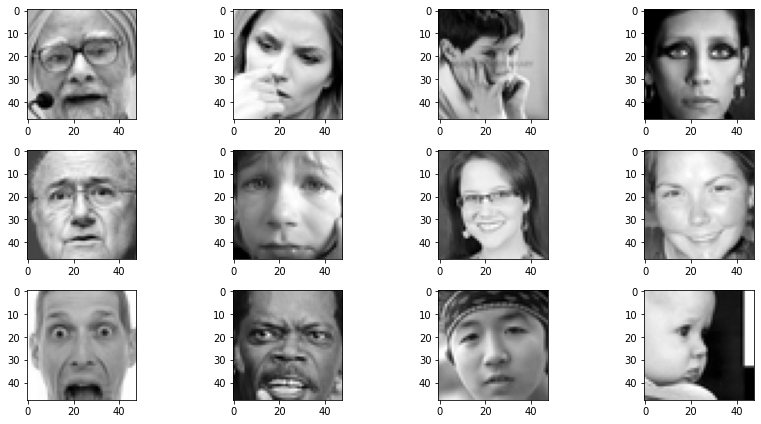

In [15]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [16]:
model = Sequential()

model.add(Conv2D(64, 3, kernel_initializer="he_normal", input_shape=(48, 48, 1),activation='relu'))
model.add(Conv2D(64, 3,activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(32, 3,activation='relu'))
model.add(Conv2D(32, 3,activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                    

In [22]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


In [23]:
filepath = "best_model_{epoch:02d}.h5"

In [30]:
mc = ModelCheckpoint(filepath,monitor='val_accuracy',mode= 'max',save_best_only=True)

In [31]:
es = EarlyStopping(monitor= 'val_loss',mode ='min',patience=20)

In [32]:
# num epochs
epochs = 100

# run model
hist = model.fit(x_train, y_train,batch_size=40, epochs=epochs, callbacks=[es,mc],validation_data=(x_test, y_test))


Epoch 1/100
718/718 [==============================] - 9s 12ms/step - loss: 1.8044 - accuracy: 0.2549 - val_loss: 1.9641 - val_accuracy: 0.2494
Epoch 2/100
718/718 [==============================] - 9s 12ms/step - loss: 1.8052 - accuracy: 0.2550 - val_loss: 1.9513 - val_accuracy: 0.2497
Epoch 3/100
718/718 [==============================] - 9s 12ms/step - loss: 1.8079 - accuracy: 0.2547 - val_loss: 1.9233 - val_accuracy: 0.2499
Epoch 4/100
718/718 [==============================] - 9s 12ms/step - loss: 1.8102 - accuracy: 0.2548 - val_loss: 1.8825 - val_accuracy: 0.2488
Epoch 5/100
718/718 [==============================] - 9s 12ms/step - loss: 1.8045 - accuracy: 0.2549 - val_loss: 1.8736 - val_accuracy: 0.2491
Epoch 6/100
718/718 [==============================] - 9s 12ms/step - loss: 1.8047 - accuracy: 0.2551 - val_loss: 1.8752 - val_accuracy: 0.2494
Epoch 7/100
718/718 [==============================] - 9s 12ms/step - loss: 1.8035 - accuracy: 0.2551 - val_loss: 1.8890 - val_accuracy:

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

In [ ]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [ ]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [ ]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
score

[1.236521938977118, 0.5257731959095039]

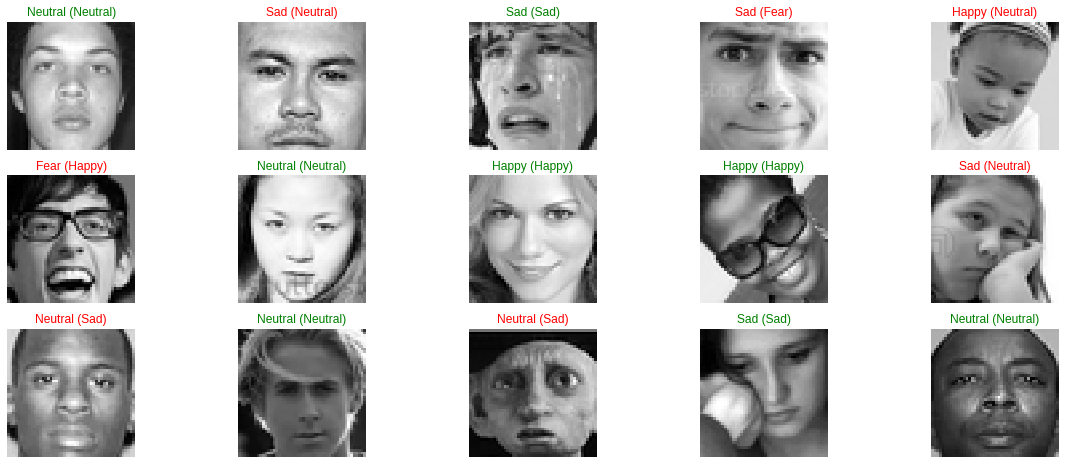

In [ ]:
y_hat = model.predict(x_test_private)

face_exp_labels=["Angry", "Disgust",
                     "Fear", "Happy",
                     "Sad", "Surprise",
                     "Neutral"]

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test_private.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test_private[index]),cmap="gray")
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test_private[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(face_exp_labels[predict_index], 
                                  face_exp_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))